In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import functools
import alive_progress
from alive_progress import alive_bar

In [11]:
df1 = pd.DataFrame(yf.download("RUB=X", start="2004-02-13", end="2021-12-31")['Close']) 
df1.columns = ['USD Close']
df2 = pd.DataFrame(yf.download("EURRUB=X", start="2004-02-13", end="2021-12-31")['Close'])
df2.columns = ['EURRUB Close']
df3 = pd.DataFrame(yf.download("GBPRUB=X", start="2004-02-13", end="2021-12-31")['Close'])
df3.columns = ['GBPRUB Close']
df4 = pd.DataFrame(yf.download("INR=X", start="2004-02-13", end="2021-12-31")['Close'])
df4.columns = ['INR Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [12]:
rates1 = pd.ExcelFile("Валюты.xlsx").parse("Лист1")
rates1.index = rates1['Date']
rates1 = rates1.drop('Date', axis=1)
rates2 = pd.ExcelFile("Валюты.xlsx").parse("Лист2")
rates2.index = rates2['Date']
rates2 = rates2.drop('Date', axis=1)
rates3 = pd.ExcelFile("Валюты.xlsx").parse("Лист3")
rates3.index = rates3['Date']
rates3 = ((1+rates3.drop('Date', axis=1)/100)**(1/252)-1)
rates4 = pd.ExcelFile("mos.xlsx").parse("Sheet1")
rates4.index = rates4['Date']
rates4 = ((1+rates4.drop('Date', axis=1)/100)**(1/252)-1)
rates4


df_rates = rates1.merge(rates2, on = 'Date')
data1 = ((1+df_rates[['Value USD', 'Value GBP', 'Value EUR']]/100)**(1/252)-1)
rates_final = data1.merge(rates3, on = 'Date')
rates_final.index = pd.to_datetime(rates_final.index)
rates_final = rates_final.merge(rates4, on = 'Date')



In [13]:
df = df1.merge(df2, on = 'Date').merge(df3, on = 'Date').merge(df4, on = 'Date')   

In [14]:
df = df.merge(rates_final, on = 'Date')

In [15]:
train, test = df[:'2017-12-29'], df['2018-01-01':]
train.columns

Index(['USD Close', 'EURRUB Close', 'GBPRUB Close', 'INR Close', 'Value USD',
       'Value GBP', 'Value EUR', 'Value INR', 'RUB value'],
      dtype='object')

In [16]:
def get_sharp_momentum(b, m):
    cum_ret_lst = [[],[],[],[]]
    sigma = []
    log_ret = [] 
    for z in range(len(['USD Close', 'EURRUB Close', 'GBPRUB Close', 'INR Close'])):
        element = ['USD Close', 'EURRUB Close', 'GBPRUB Close', 'INR Close'][z]
        column = ['Value USD', 'Value EUR', 'Value GBP', 'Value INR'][z]
        ret = []
        cum_ret_lst[z].append(0)
        for i in range(m, pd.DataFrame(train[element]).shape[0]):
            ok = 1
            ok2 = 1
            cum_ret = 0
            for j in range(m):
                cum_ret += np.log(train[element][i-j-1]) - np.log(train[element][i-j-2])
                if cum_ret < b:
                    ok = 0
                if cum_ret > -b:
                    ok2 = 0
            
            # + r*np.log(train[element][i-1]) foreign interest
            # print(ok, ok2, ret_loc)
            if ok == 1 and train[column][i-1] >= 0:
                ret_loc = np.log(train[element][i]) - np.log(train[element][i-1]) + np.log(1+train[column][i-1])-np.log(1+train['RUB value'][i-1])
                ret.append(ret_loc)
            elif ok == 1 and train[column][i-1] < 0:
                ret_loc = np.log(train[element][i]) - np.log(train[element][i-1])-np.log(1+train['RUB value'][i-1])
                ret.append(ret_loc)
            elif ok2 == 1 and train[column][i-1] >= 0:
                ret_loc = np.log(train[element][i]) - np.log(train[element][i-1]) + np.log(1+train[column][i-1])-np.log(1+train['RUB value'][i-1])
                ret.append(-ret_loc)
            elif ok2 == 1 and train[column][i-1] < 0:
                ret_loc = np.log(train[element][i]) - np.log(train[element][i-1]) -np.log(1+train['RUB value'][i-1])
                ret.append(-ret_loc)
            else:
                ret.append(0)

            cum_ret_lst[z].append(cum_ret_lst[z][-1] + ret[-1]) # При добавлении доходности весь прошлый ретерн должен домножаться на рублевую ставку

        # plt.plot(cum_ret_lst)
        # annual volatility of the strategy
        log_ret.append(ret)
    return(cum_ret_lst, log_ret)

In [18]:
# Прокручиваем еще раз тресхолд и лаг с оптимальными весами
sharp_list = []
w1 = 0.5
w2 = -0.25
w3 = -0.5
answers = [[],[]]
with alive_bar(480, force_tty = True) as bar:
    for b in np.arange(0.001, 0.05, 0.003):
        for m in range(1, 30, 1):
            usd = get_sharp_momentum(0.05, 5)[0][0]
            eur = get_sharp_momentum(0.05, 5)[0][1]
            pound = get_sharp_momentum(0.05, 5)[0][2]
            rup = get_sharp_momentum(0.05, 5)[0][3]
            weights = np.array([w1, w2, w3, 1-w1-w2-w3])
            log_returns = np.array(get_sharp_momentum(b,m)[1])

            mean_usd = np.mean(log_returns[0])
            mean_eur = np.mean(log_returns[1])
            mean_pound = np.mean(log_returns[2])
            mean_rup = np.mean(log_returns[3])
            mean = w1*mean_usd + w2*mean_eur +  w3*mean_pound + (1-w1-w2-w3) * mean_rup
            sd = np.sqrt(np.dot(weights.T,np.dot(np.cov(log_returns)*252,weights)))
            sharp = mean/sd
            sharp_list.append(sharp)
            answers[0].append(b)
            answers[1].append(m)
            bar()

|████████████████████████████████████████✗︎ (!) 493/480 [103%] in 41:37.1 (0.20/s)                                       s, 0.0/s) 0/480 [0%] in 2s (~0s, 0.0/s) ▃▁▃ 0/480 [0%] in 3s (~0s, 0.0/s)  █▆▄ 0/480 [0%] in 4s (~0s, 0.0/s) ▇▅▃ 0/480 [0%] in 4s (~0s, 0.0/s) ▄▂▂ 0/480 [0%] in 5s (~0s, 0.0/s) ▅▇▇ 0/480 [0%] in 6s (~0s, 0.0/s) 0/480 [0%] in 7s (~0s, 0.0/s) in 53s (~46:53, 0.2/s)  11/480 [2%] in 1:02 (~45:32, 0.2/s) (~42:11, 0.2/s) in 2:41 (~42:57, 0.2/s) 31/480 [6%] in 2:50 (~41:49, 0.2/s) 37/480 [8%] in 3:14 (~38:35, 0.2/s) in 3:23 (~38:05, 0.2/s) in 3:36 (~37:22, 0.2/s) in 3:39 (~37:21, 0.2/s) in 4:07 (~36:54, 0.2/s) in 4:26 (~37:00, 0.2/s) 52/480 [11%] in 4:30 (~36:50, 0.2/s) 54/480 [11%] in 4:39 (~36:56, 0.2/s) 57/480 [12%] in 4:59 (~37:03, 0.2/s) in 5:00 (~37:03, 0.2/s) in 5:37 (~34:45, 0.2/s) in 5:41 (~34:35, 0.2/s) in 5:54 (~34:27, 0.2/s) (~34:15, 0.2/s) in 6:59 (~34:09, 0.2/s) in 7:00 (~34:02, 0.2/s) (~34:02, 0.2/s) in 7:25 (~34:09, 0.2/s) in 7:48 (~33:16, 0.2/s) in 8:11 (~3

In [20]:
print(answers[0][sharp_list.index(np.max(sharp_list))])
print(answers[1][sharp_list.index(np.max(sharp_list))])
# m=1; b = 0.016

0.016
1


In [21]:
w1 = 1
w2 = -1
w3 = -1
def get_profit(b, m):
    cum_ret_lst = [[],[],[],[]]
    trade = [[],[],[],[]]
    sigma = []
    log_ret = [] 
    for z in range(len(['USD Close', 'EURRUB Close', 'GBPRUB Close', 'INR Close'])):
        element = ['USD Close', 'EURRUB Close', 'GBPRUB Close', 'INR Close'][z]
        column = ['Value USD', 'Value EUR', 'Value GBP', 'Value INR'][z]
        ret = []
        cum_ret_lst[z].append(0)
        for i in range(m, pd.DataFrame(test[element]).shape[0]):
            ok = 1
            ok2 = 1
            cum_ret = 0
            for j in range(m):
                cum_ret += np.log(test[element][i-j-1]) - np.log(test[element][i-j-2])
                if cum_ret < b:
                    ok = 0
                if cum_ret > -b:
                    ok2 = 0
            
            # + r*np.log(train[element][i-1]) foreign interest
            # print(ok, ok2, ret_loc)
            if ok == 1 and test[column][i-1] >= 0:
                ret_loc = np.log(test[element][i]) - np.log(test[element][i-1]) + np.log(1+test[column][i-1])-np.log(1+test['RUB value'][i-1])
                ret.append(0.9975*ret_loc)
            elif ok == 1 and test[column][i-1] < 0:
                ret_loc = np.log(test[element][i]) - np.log(test[element][i-1])-np.log(1+test['RUB value'][i-1])
                ret.append(0.9975*ret_loc)
            elif ok2 == 1 and test[column][i-1] >= 0:
                ret_loc = np.log(test[element][i]) - np.log(test[element][i-1]) + np.log(1+test[column][i-1])-np.log(1+test['RUB value'][i-1])
                ret.append(-ret_loc*0.9975)
            elif ok2 == 1 and test[column][i-1] < 0:
                ret_loc = np.log(test[element][i]) - np.log(test[element][i-1]) -np.log(1+test['RUB value'][i-1])
                ret.append(-ret_loc*0.99975)
            else:
                ret.append(np.log(1+test['RUB value'][i]+np.random.uniform(-0.0005,0.0005)))

            cum_ret_lst[z].append(cum_ret_lst[z][-1] + ret[-1]) # При добавлении доходности весь прошлый ретерн должен домножаться на рублевую ставку
            trade[z].append(1*ok+1*ok2)
        # plt.plot(cum_ret_lst)
        # annual volatility of the strategy
        log_ret.append(ret)
    return(cum_ret_lst, log_ret, trade)

In [22]:
usd = np.array(get_profit(0.016, 1)[0][0])
eur = np.array(get_profit(0.016, 1)[0][1])
pound = np.array(get_profit(0.016, 1)[0][2])
rup = np.array(get_profit(0.016, 1)[0][3])

In [23]:
weighted_cum_ret = w1*usd+w2*eur+w3*pound + (1-w1-w2-w3)*rup

In [24]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'cumulative log return')

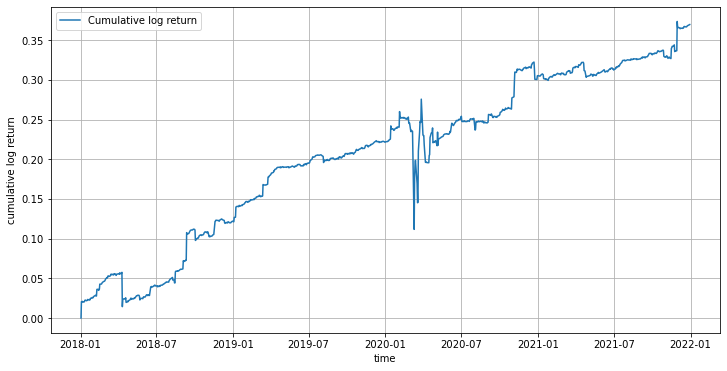

In [25]:
plt.figure(figsize=(12, 6))
display(plt.plot(df['2018-01-01':].index,weighted_cum_ret, label = 'Cumulative log return'))
plt.grid()
plt.legend()
plt.xlabel('time')
plt.ylabel('cumulative log return')

In [26]:
df5 = pd.read_csv('UUP.csv')
df5.index = pd.to_datetime(df5['Date'])
df5 = df5.drop('Date', axis = 1)
df5_new = df5.merge(df1, on = 'Date')
df5_new['Value rub'] = df5_new['Close']*df5_new['USD Close']
df5_new

data = np.array(df5_new['Value rub'])
log_ret = []
for i in range(len(data)):
    if i != len(data)-1:
        log_ret.append(np.log(data[i+1])-np.log(data[i]))
        
log_ret
cum_log_ret = [0]
for element in log_ret:
    cum_log_ret.append(cum_log_ret[-1]+element)

In [27]:
np.std(np.array(log_ret))*252**0.5

0.1547507074043675

Text(0, 0.5, 'cumulative log return')

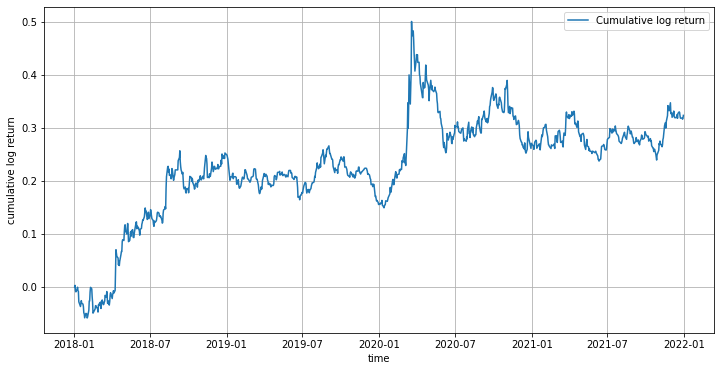

In [28]:
plt.figure(figsize=(12, 6))
display(plt.plot(df5_new.index, cum_log_ret, label = 'Cumulative log return'))
plt.grid()
plt.legend()
plt.xlabel('time')
plt.ylabel('cumulative log return')

In [29]:
df6 = pd.read_csv('FXB.csv')
df6.index = pd.to_datetime(df6['Date'])
df6 = df6.drop('Date', axis = 1)
df6_new = df6.merge(df1, on = 'Date')
df6_new['Value rub'] = df6_new['Close']*df6_new['USD Close']
df6_new

data2 = np.array(df6_new['Value rub'])
log_ret2 = []
for i in range(len(data2)):
    if i != len(data2)-1:
        log_ret2.append(np.log(data2[i+1])-np.log(data2[i]))
        
log_ret2
cum_log_ret2 = [0]
for element in log_ret2:
    cum_log_ret2.append(cum_log_ret2[-1]+element)

In [30]:
np.std(np.array(log_ret2))*252**0.5

0.15123315882497176

Text(0, 0.5, 'cumulative log return')

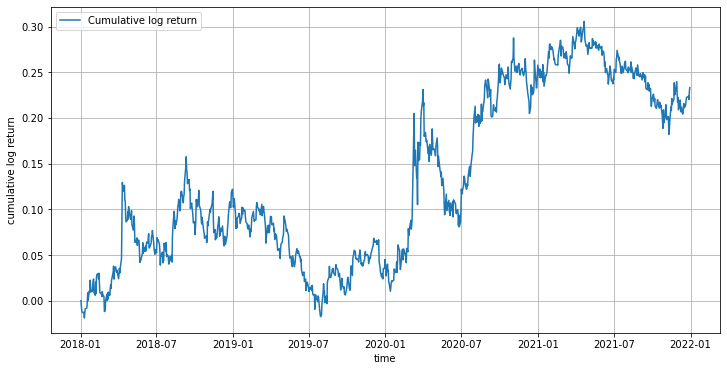

In [32]:
plt.figure(figsize=(12, 6))
display(plt.plot(df6_new.index, cum_log_ret2, label = 'Cumulative log return'))
plt.grid()
plt.legend()
plt.xlabel('time')
plt.ylabel('cumulative log return')

Text(0, 0.5, 'cumulative log return')

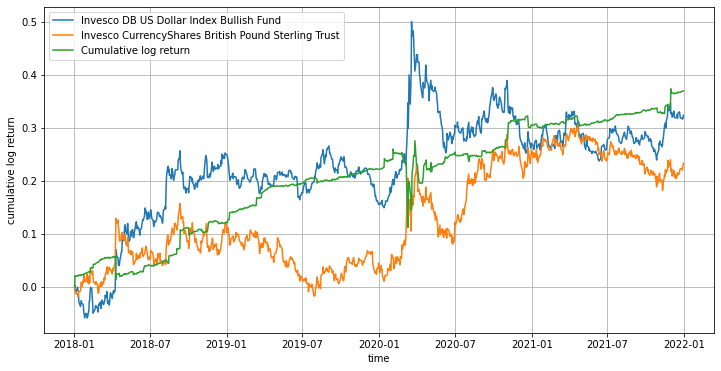

In [33]:
plt.figure(figsize=(12, 6))
display(plt.plot(df5_new.index, cum_log_ret, label = 'Invesco DB US Dollar Index Bullish Fund'))
display(plt.plot(df6_new.index, cum_log_ret2, label = 'Invesco CurrencyShares British Pound Sterling Trust'))
display(plt.plot(df['2018-01-01':].index,weighted_cum_ret, label = 'Cumulative log return'))
plt.grid()
plt.legend()
plt.xlabel('time')
plt.ylabel('cumulative log return')

In [34]:
usd_hold = get_profit(0.016, 1)[2][0].count(0)/len(get_profit(0.016, 1)[2][0])
usd_trade = 1-get_profit(0.016, 1)[2][0].count(0)/len(get_profit(0.016, 1)[2][0])
eur_hold = get_profit(0.016, 1)[2][1].count(0)/len(get_profit(0.016, 1)[2][1])
eur_trade = 1-get_profit(0.016, 1)[2][1].count(0)/len(get_profit(0.016, 1)[2][1])
pound_hold = get_profit(0.016, 1)[2][2].count(0)/len(get_profit(0.016, 1)[2][2])
pound_trade = 1-get_profit(0.016, 1)[2][2].count(0)/len(get_profit(0.016, 1)[2][2])
rup_hold = get_profit(0.016, 1)[2][3].count(0)/len(get_profit(0.016, 1)[2][3])
rup_trade = 1-get_profit(0.016, 1)[2][3].count(0)/len(get_profit(0.016, 1)[2][3])

In [35]:
rup_trade

0.008910891089108919

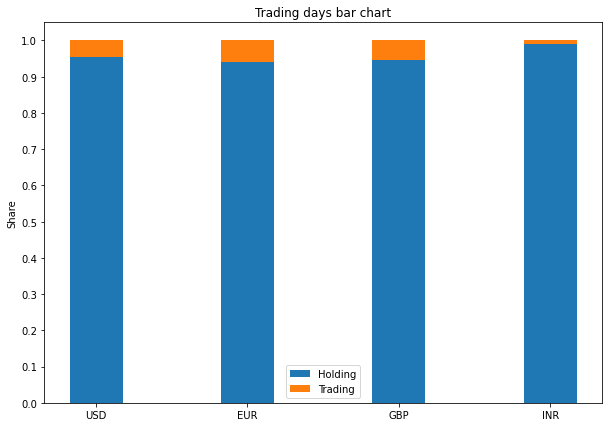

In [36]:
ind = np.arange(4)
hold = [usd_hold, eur_hold, pound_hold, rup_hold]
trade = [usd_trade, eur_trade, pound_trade, rup_trade]
fig = plt.subplots(figsize =(10, 7))
p1 = plt.bar(ind, hold, 0.35)
p2 = plt.bar(ind, trade, 0.35,
             bottom = hold)
 
plt.ylabel('Share')
plt.title('Trading days bar chart')
plt.xticks(ind, ('USD', 'EUR', 'GBP', 'INR'))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend((p1[0], p2[0]), ('Holding', 'Trading'))
 
plt.show()

Text(0, 0.5, 'Log return')

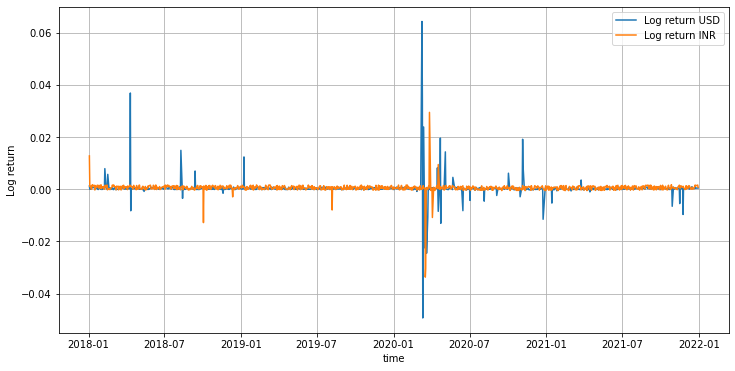

In [37]:
cum_ret = get_profit(0.016, 1)[1]
plt.figure(figsize=(12, 6))
display(plt.plot(df['2018-01-03':].index,cum_ret[0], label = 'Log return USD'))
display(plt.plot(df['2018-01-03':].index,2*np.array(cum_ret[3]), label = 'Log return INR'))
plt.grid()
plt.legend()
plt.xlabel('time')
plt.ylabel('Log return')

Text(0, 0.5, 'Log return')

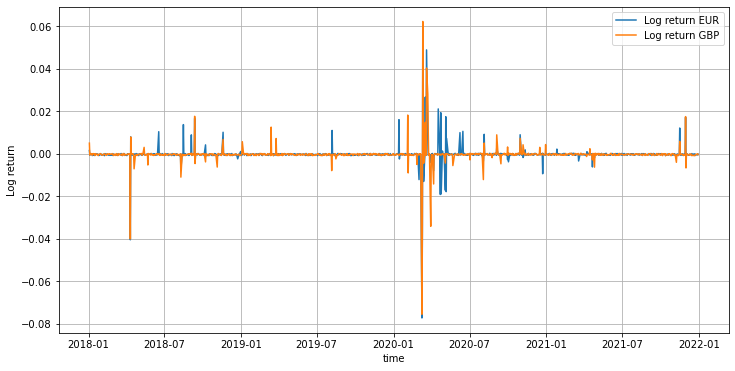

In [38]:
cum_ret = get_profit(0.016, 1)[1]
plt.figure(figsize=(12, 6))
display(plt.plot(df['2018-01-03':].index,(-1)*np.array(cum_ret[1]), label = 'Log return EUR'))
display(plt.plot(df['2018-01-03':].index,(-1)*np.array(cum_ret[2]), label = 'Log return GBP'))
plt.grid()
plt.legend()
plt.xlabel('time')
plt.ylabel('Log return')

Text(0, 0.5, 'Log return')

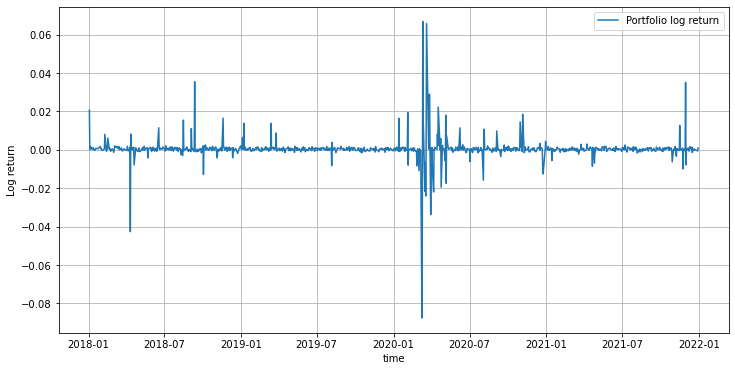

In [39]:
cum_ret = get_profit(0.016, 1)[1]
plt.figure(figsize=(12, 6))
display(plt.plot(df['2018-01-03':].index,np.array(cum_ret[0])-np.array(cum_ret[1])-np.array(cum_ret[2])+2*np.array(cum_ret[3]), label = 'Portfolio log return'))
plt.grid()
plt.legend()
plt.xlabel('time')
plt.ylabel('Log return')

In [40]:
w1= 1
w2 = -1
w3 = -1
w4 = 2
weights = np.array([w1, w2, w3, 1-w1-w2-w3])
log_returns = np.array(get_sharp_momentum(0.016,1)[0])

mean_usd = np.mean(log_returns[-1])
mean_eur = np.mean(log_returns[-1])
mean_pound = np.mean(log_returns[-1])
mean_rup = np.mean(log_returns[-1])
mean = w1*mean_usd + w2*mean_eur +  w3*mean_pound + (1-w1-w2-w3) * mean_rup
sd = np.sqrt(np.dot(weights.T,np.dot(np.cov(log_returns)*252,weights)))
sharp = mean/sd
sharp

-0.0062720150085963655

In [42]:
sd_new = np.array(cum_ret[0])-np.array(cum_ret[1])-np.array(cum_ret[2])+2*np.array(cum_ret[3])
np.std(sd_new)*252**0.5

0.09257006220353681